## Load libraries and pretrained weak models

In [1]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import pickle
import numpy as np
import sys
import sklearn.svm.classes
import pandas as pd
import os
#path constants
train_path = '../../data/train'
test_path = '../../data/test'

#type constants
vehicle_types = ['ZVe44', 'ZV573', 'ZV63d', 'ZVfd4', 'ZVa9c', 'ZVa78', 'ZV252']

#two label dataframes
train_label_df = pd.read_csv(train_path + '/train_label.csv', delimiter = ',', encoding = 'utf-8')
test_label_df = pd.read_csv(test_path + '/test_label.csv', delimiter = ',', encoding = 'utf-8')

#sys.path.append(r'D:/ProgramData/Anaconda3/Lib/site-packages/sklearn/svm/')

cluster_n = 50

#load all the cluster oriented models and map them with the corresponding vehicle type
saved_model_path = '../XGBoost/'
GBDT_map = dict()
for vehicle_type in vehicle_types:
    GBDT_list = list()
    for i in range(cluster_n):
        fn = saved_model_path +vehicle_type+'/trainedXGB'+str(i)+'.pkl'
        print(fn)
        if not os.path.isfile(fn):
            #corner case of ZV252 cluster 30 : all data samples are negative 
            GBDT_list.append(0)
            continue
        with open(fn, 'rb') as file:
            pickle_model = pickle.load(file)
            GBDT_list.append(pickle_model)
    GBDT_map[vehicle_type] = GBDT_list

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.
  warnings.warn(message, FutureWarning)


../XGBoost/ZVe44/trainedXGB0.pkl
../XGBoost/ZVe44/trainedXGB1.pkl
../XGBoost/ZVe44/trainedXGB2.pkl
../XGBoost/ZVe44/trainedXGB3.pkl
../XGBoost/ZVe44/trainedXGB4.pkl
../XGBoost/ZVe44/trainedXGB5.pkl
../XGBoost/ZVe44/trainedXGB6.pkl
../XGBoost/ZVe44/trainedXGB7.pkl
../XGBoost/ZVe44/trainedXGB8.pkl
../XGBoost/ZVe44/trainedXGB9.pkl
../XGBoost/ZVe44/trainedXGB10.pkl
../XGBoost/ZVe44/trainedXGB11.pkl
../XGBoost/ZVe44/trainedXGB12.pkl
../XGBoost/ZVe44/trainedXGB13.pkl
../XGBoost/ZVe44/trainedXGB14.pkl
../XGBoost/ZVe44/trainedXGB15.pkl
../XGBoost/ZVe44/trainedXGB16.pkl
../XGBoost/ZVe44/trainedXGB17.pkl
../XGBoost/ZVe44/trainedXGB18.pkl
../XGBoost/ZVe44/trainedXGB19.pkl
../XGBoost/ZVe44/trainedXGB20.pkl
../XGBoost/ZVe44/trainedXGB21.pkl
../XGBoost/ZVe44/trainedXGB22.pkl
../XGBoost/ZVe44/trainedXGB23.pkl
../XGBoost/ZVe44/trainedXGB24.pkl
../XGBoost/ZVe44/trainedXGB25.pkl
../XGBoost/ZVe44/trainedXGB26.pkl
../XGBoost/ZVe44/trainedXGB27.pkl
../XGBoost/ZVe44/trainedXGB28.pkl
../XGBoost/ZVe44/trained

../XGBoost/ZV252/trainedXGB33.pkl
../XGBoost/ZV252/trainedXGB34.pkl
../XGBoost/ZV252/trainedXGB35.pkl
../XGBoost/ZV252/trainedXGB36.pkl
../XGBoost/ZV252/trainedXGB37.pkl
../XGBoost/ZV252/trainedXGB38.pkl
../XGBoost/ZV252/trainedXGB39.pkl
../XGBoost/ZV252/trainedXGB40.pkl
../XGBoost/ZV252/trainedXGB41.pkl
../XGBoost/ZV252/trainedXGB42.pkl
../XGBoost/ZV252/trainedXGB43.pkl
../XGBoost/ZV252/trainedXGB44.pkl
../XGBoost/ZV252/trainedXGB45.pkl
../XGBoost/ZV252/trainedXGB46.pkl
../XGBoost/ZV252/trainedXGB47.pkl
../XGBoost/ZV252/trainedXGB48.pkl
../XGBoost/ZV252/trainedXGB49.pkl


## Visualize a weak model

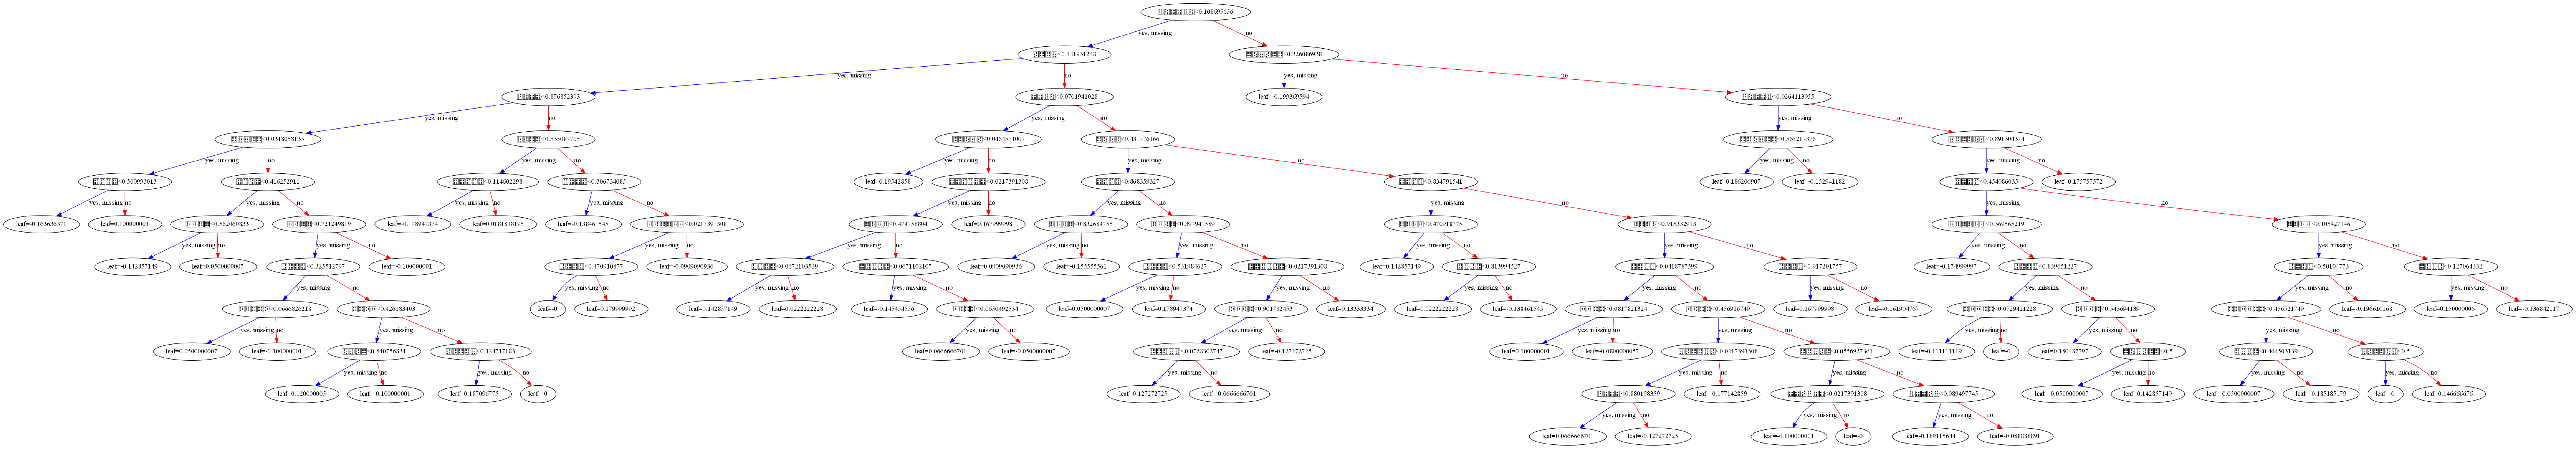

In [11]:
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 200,200
models = GBDT_map['ZV252']
model = models[0]
from xgboost import plot_tree
import matplotlib.pyplot as plt
plot_tree(model)
plt.savefig('./tree.png')
plt.show()

## Load data and label as well as for each sample, pass the data points to their corresponding weak model to generate pooling score tensor

In [95]:
def getLabel(filename, label_df):
    idx = label_df.loc[label_df['sample_file_name'] == filename]
    return idx.iloc[0]['label']



def feature_tensor_gen(path, label_df, model_list):
#path: train_path or test_path
#vehicle_type: one string element under vehicle_types = ['ZVe44', 'ZV573', 'ZV63d', 'ZVfd4', 'ZVa9c', 'ZVa78', 'ZV252']
    
    #these are variables to calculate traversing progress (DO NOT CHANGE)
    counts_per_percent = int(len(os.listdir(path)) / 100)
    percentage_completion = 0
    counter = 0
    
    #pooling result from 50 weak learners then concatenated with the label
    feature_tensor = np.empty((0, cluster_n+1))
    
    for file in os.listdir(path):
        if file == 'clustered':
            continue
        sample_df = pd.read_csv(path + '/' + file, delimiter = ',', encoding = 'utf-8')
        n = len(sample_df)
        # NO NEED TO CHANGE ANYTHING ABOVE
        # --------------------------------------------------------------------------
        label = getLabel(file, label_df)
        np_arr = sample_df.to_numpy()
        
        feature_vector = list()
        
        if np_arr.shape[0] == 0:
            continue
            
        for i in range(cluster_n):
            input_vector = np_arr[np_arr[:,-1] == i]
            df = sample_df[sample_df['cluster_n'] == i]
            
            if input_vector.shape[0] == 0:
                feature_vector.append(np.nan)
                continue
                
            model = model_list[i]
            pooling_score = 0
            if model == 0:
                #corner case of ZV252 cluster 30
                pooling_score = 0
            else:
                result = model.predict(df.iloc[:,:-1], validate_features=False)
                pooling_score = np.average(result)
            feature_vector.append(pooling_score)
        
        feature_vector.append(label)
        feature_vector = np.array(feature_vector) 
        feature_tensor = np.append(feature_tensor, [feature_vector], axis=0)
        # --------------------------------------------------------------------------
        # NO NEED TO CHANGE ANYTHING BELOW
        
        #belows are to show traversing progress (DO NOT CHANGE)
        counter += 1
        if counter == counts_per_percent:
            counter = 0
            percentage_completion += 1
            print('traversing files under', path, ':', percentage_completion, "%", end="\r", flush=True)
    return feature_tensor

In [96]:
train_tensor = dict()
test_tensor = dict()

path_train_prefix = '../../cleaned_data/train/'
path_test_prefix = '../../cleaned_data/test/'
path_postfix = '/clustered/'

for vehicle_type in vehicle_types:
    
    path_train_prefix = '../../cleaned_data/train/'
    path_test_prefix = '../../cleaned_data/test/'
    path_postfix = '/clustered/'
    train_tensor[vehicle_type] = feature_tensor_gen(path_train_prefix+vehicle_type+path_postfix, train_label_df, GBDT_map[vehicle_type])
    test_tensor[vehicle_type] = feature_tensor_gen(path_test_prefix+vehicle_type+path_postfix, test_label_df, GBDT_map[vehicle_type])

## Save score tensors

In [97]:
print(feature_tensor.shape)
for vehicle_type in vehicle_types:
    trainset = train_tensor[vehicle_type]
    testset = test_tensor[vehicle_type]
    np.savetxt(vehicle_type+"_train.csv", trainset, delimiter=",")
    np.savetxt(vehicle_type+"_test.csv", trainset, delimiter=",")
    

(9335, 51)


In [98]:
# from sklearn import metrics
# from sklearn.metrics import accuracy_score
# lrm = LogisticRegression(max_iter = 1000000, penalty = 'l2', tol = 1e-10, C = 1)
# lrm.coef_ = np.repeat(1,50)
# coef = lrm.coef_
# print(np.sum(coef))
# lrm.fit(x_train, y_train)
# coef = lrm.coef_
# print(np.sum(coef))
# print(coef)
# y_hat = lrm.predict(x_test)
# print(accuracy_score(y_test, y_hat))
# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat, pos_label=1)
# print(metrics.auc(fpr, tpr))

## Exploration of different settings of GBDT kernel to classify samples based on the scores

In [103]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
def performance_summary(vehicle_type, train, test):
    print('Model performance report for vehicle type:', vehicle_type)
    params = {'booster': 'gbtree', 'eta': 1, 'max_depth': 20, 'gamma' : 0}
    bst = xgb.XGBClassifier(**params)
    bst.fit(train[:,:50],train[:,50])
    
    y_hat = bst.predict(train[:,:50])
    acc = accuracy_score(train[:,50], y_hat)
    print('train acc:',acc)
    y_hat = bst.predict(test[:,:50])
    acc = accuracy_score(test[:,50], y_hat)
    print('test acc:',acc)
    fpr, tpr, thresholds = metrics.roc_curve(test[:,50], y_hat, pos_label=1)
    print('AUC:',metrics.auc(fpr, tpr))
    with open('./'+vehicle_type+'_integrated_model_v2.pkl', 'wb') as f:
                pickle.dump(bst,f)
    return acc * test.shape[0]

correct = 0
nums = 0
for vehicle_type in vehicle_types:
    nums += test_tensor[vehicle_type].shape[0]
    correct += performance_summary(vehicle_type, train_tensor[vehicle_type], test_tensor[vehicle_type])
print('Overal test acc:', correct / nums)

Model performance report for vehicle type: ZVe44
train acc: 1.0
test acc: 0.5725152762189799
AUC: 0.569009097929638
Model performance report for vehicle type: ZV573
train acc: 0.9898057262691871
test acc: 0.5633538314246788
AUC: 0.5611485218259095
Model performance report for vehicle type: ZV63d
train acc: 1.0
test acc: 0.5748031496062992
AUC: 0.5851778656126482
Model performance report for vehicle type: ZVfd4
train acc: 1.0
test acc: 0.7017994858611826
AUC: 0.68810051736881
Model performance report for vehicle type: ZVa9c
train acc: 1.0
test acc: 0.5607685433422699
AUC: 0.5344151787719306
Model performance report for vehicle type: ZVa78
train acc: 1.0
test acc: 0.570474002923366
AUC: 0.5520789001822619
Model performance report for vehicle type: ZV252
train acc: 0.985663082437276
test acc: 0.5032679738562091
AUC: 0.5010263427984947
Overal test acc: 0.5671220604703248


In [104]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
def performance_summary(vehicle_type, train, test):
    print('Model performance report for vehicle type:', vehicle_type)
    params = {'booster': 'gbtree', 'eta': 1, 'max_depth': 30, 'gamma' :0.1}
    bst = xgb.XGBClassifier(**params)
    bst.fit(train[:,:50],train[:,50])
    
    y_hat = bst.predict(train[:,:50])
    acc = accuracy_score(train[:,50], y_hat)
    print('train acc:',acc)
    y_hat = bst.predict(test[:,:50])
    acc = accuracy_score(test[:,50], y_hat)
    print('test acc:',acc)
    fpr, tpr, thresholds = metrics.roc_curve(test[:,50], y_hat, pos_label=1)
    print('AUC:',metrics.auc(fpr, tpr))
    with open('./'+vehicle_type+'_integrated_model_v2.pkl', 'wb') as f:
                pickle.dump(bst,f)
    return acc * test.shape[0]

correct = 0
nums = 0
for vehicle_type in vehicle_types:
    nums += train_tensor[vehicle_type].shape[0]
    correct += performance_summary(vehicle_type, test_tensor[vehicle_type], train_tensor[vehicle_type])
print('Overal test acc:', correct / nums)

Model performance report for vehicle type: ZVe44
train acc: 0.9996258885147774
test acc: 0.7186930905195501
AUC: 0.7196938177201182
Model performance report for vehicle type: ZV573
train acc: 0.9908310932724528
test acc: 0.6713366149185914
AUC: 0.670141303373367
Model performance report for vehicle type: ZV63d
train acc: 0.9984251968503937
test acc: 0.7905151825315592
AUC: 0.7926380548827018
Model performance report for vehicle type: ZVfd4
train acc: 0.9794344473007712
test acc: 0.6951530612244898
AUC: 0.6818555409874563
Model performance report for vehicle type: ZVa9c
train acc: 0.9937444146559428
test acc: 0.7557788944723618
AUC: 0.7326054068822417
Model performance report for vehicle type: ZVa78
train acc: 0.9997911881394863
test acc: 0.6603911533540486
AUC: 0.6668574908125677
Model performance report for vehicle type: ZV252
train acc: 0.954248366013072
test acc: 0.43010752688172044
AUC: 0.3988835725677831
Overal test acc: 0.6879967211946256


In [87]:
train_tensor_ = dict()
test_tensor_ = dict()
for vehicle_type in vehicle_types:
    train_tensor_[vehicle_type] = np.nan_to_num(train_tensor[vehicle_type], nan = 0.5)
    test_tensor_[vehicle_type] = np.nan_to_num(test_tensor[vehicle_type], nan = 0.5)

In [88]:
for vehicle_type in vehicle_types:
    performance_summary(vehicle_type, train_tensor_[vehicle_type], test_tensor_[vehicle_type])

Model performance report for vehicle type: ZVe44
train acc: 0.9996786288162828
test acc: 0.545329841626138
AUC: 0.5453775067487173
0.545329841626138 8019 4373.0
Model performance report for vehicle type: ZV573
train acc: 0.9939708152506335
test acc: 0.5484037264793608
AUC: 0.548319687178244
0.5484037264793608 27157 14893.0
Model performance report for vehicle type: ZV63d
train acc: 1.0
test acc: 0.5506561679790026
AUC: 0.5474449463579899
0.5506561679790026 1905 1049.0
Model performance report for vehicle type: ZVfd4
train acc: 1.0
test acc: 0.622107969151671
AUC: 0.5372533970094945
0.622107969151671 389 242.00000000000003
Model performance report for vehicle type: ZVa9c
train acc: 1.0
test acc: 0.58266309204647
AUC: 0.5522613414121288
0.58266309204647 2238 1304.0
Model performance report for vehicle type: ZVa78
train acc: 0.9998172180588558
test acc: 0.5237001461683024
AUC: 0.5247292451151218
0.5237001461683024 4789 2508.0
Model performance report for vehicle type: ZV252
train acc: 0.9

## Logistic regression kernel

In [90]:
def lrm_report(vehicle_type, train, test):
    print('summary of lrm for vehicle type:', vehicle_type)
    lrm = LogisticRegression(max_iter = 1000000, penalty = 'l2', tol = 1e-10, C = 1)
    lrm.coef_ = np.repeat(0.02,50)
    coef = lrm.coef_
    lrm.fit(train[:,:50], train[:,50])
    coef = lrm.coef_
    print(coef)
    y_hat = lrm.predict(train[:,:50])
    print('train acc:',accuracy_score(train[:,50], y_hat))
    y_hat = lrm.predict(test[:,:50])
    print('test acc:',accuracy_score(test[:,50], y_hat))
    fpr, tpr, thresholds = metrics.roc_curve(test[:,50], y_hat, pos_label=1)
    print('AUC:',metrics.auc(fpr, tpr))

for vehicle_type in vehicle_types:
    lrm_report(vehicle_type, train_tensor_[vehicle_type], test_tensor_[vehicle_type])

summary of lrm for vehicle type: ZVe44
[[ 1.01421507  2.04539921  2.5430509   1.44206722  2.91694002  1.76605967
  -0.2094684   2.92978059  2.33338488  2.27967071  2.19177908  0.70427358
   2.46721738  1.96611939  2.44016076  3.15497853  1.81645848  1.89551425
   2.08397147  2.62878256  3.45811087  2.241956    1.08565912  3.11538557
   1.63563761  2.55005561  2.49423275  2.2357769   1.16189474  1.85855533
   1.76296376  1.75877919  1.63284686  1.60720154  1.80951978  1.42451235
   3.48188165  2.14073777  2.44977607  2.06657866  1.4791147   2.30965999
   1.75868033  1.64030938  2.46213567  1.92079113  0.18369642  2.37027635
   2.59418355  0.5890488 ]]
train acc: 0.9882163899303695
test acc: 0.5561790746975932
AUC: 0.556672854624977
summary of lrm for vehicle type: ZV573
[[2.30340461 1.35692299 3.77481816 3.09716772 1.3014219  1.72171821
  3.04916605 2.91364219 3.14343801 1.984716   3.57357667 3.4697569
  2.32937373 3.84469921 2.84587729 2.69364207 2.62859861 6.37628578
  2.22125097 2.46

In [91]:
for vehicle_type in vehicle_types:
    lrm_report(vehicle_type, test_tensor_[vehicle_type], train_tensor_[vehicle_type])

summary of lrm for vehicle type: ZVe44
[[-0.02498155 -0.24432238  0.13025673  0.28813197  0.46771249 -0.07114604
  -0.35910834  0.29984124  0.27059539  0.13721456  0.13838882 -0.22294358
   0.61833038  0.05520715  0.40512486  0.00490128  0.4019995   0.10422223
  -0.0165765   0.09003415  0.30974795  0.33672833  0.17171584  0.17503781
  -0.01473732  0.07939434  0.23333274  0.06566918  1.27254676 -0.07855173
   0.17635831  0.37180496  0.33502722  0.21892646  0.36701306  0.03556965
   0.17986759  0.34076645 -0.04117817 -0.01143575 -0.12736462  0.17873344
   0.0833172  -1.24591429  0.5069161  -0.20514151  0.28184859  0.22235994
   0.11051357  0.50712019]]
train acc: 0.5681506422247163
test acc: 0.9530798071772898
AUC: 0.9535930857835005
summary of lrm for vehicle type: ZV573
[[ 0.35950767  0.20604069 -0.04966243  2.51829528  0.12173121  0.34009225
   0.36650422 -0.29103908  0.01152664  0.15169666 -0.04019702  0.03579518
   0.05706085  2.06312655 -0.20096346  0.26282054 -0.05770753  1.254357